# Spectrogram Reading Lecture 8: Fricatives

1. A speech production model for unvoiced fricatives
2. Examples from wikipedia
3. A mystery sentence

## 1. A speech production model for unvoiced fricatives

### 1.a. Excitation = Turbulence at the constriction

Unvoiced fricatives are produced when (1) a tight constriction is made somewhere in the vocal tract, tight enough to generate turbulence, and (2) the glottis is opened up, to allow airflow without voicing.  

The excitation signal, $e[n]$, is caused by turbulence, which is generated at the constriction, and hits against obstacles downstream from the constriction.  A very good signal model for turbulence is a sequence of independent, identically distributed Gaussian samples.  We sometimes write $e[n]\sim{\mathcal N}(0,1)$ to mean that each sample, $e[n]$, is drawn independently from a normal (Gaussian) distribution with zero mean and unit variance.



In [9]:
import soundfile as sf
import io
import urllib.request as request
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as stats
import scipy.fftpack as fftpack

In [71]:
fs = 44100
e = stats.multivariate_normal.rvs(size=int(0.5*fs))
sf.write('whitenoise.wav',e,fs)
E = fftpack.fft(e)

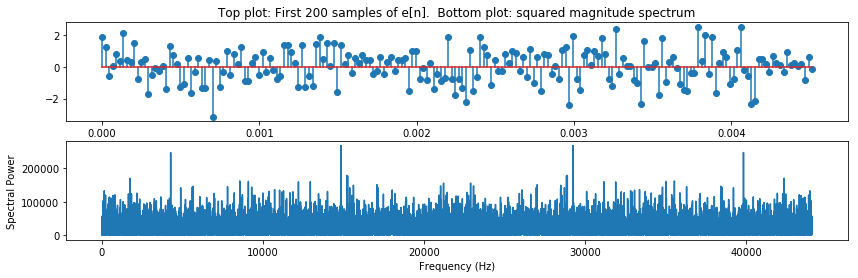

In [72]:
plt.figure(figsize=(14,4))
plt.subplot(211)
t_axis = np.linspace(0,0.5,len(e))
plt.stem(t_axis[0:200],e[0:200])
plt.title('Top plot: First 200 samples of e[n].  Bottom plot: squared magnitude spectrum')
plt.subplot(212)
f_axis = np.linspace(0,fs,len(E))
plt.plot(f_axis,np.square(np.absolute(E)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Spectral Power')

The bottom plot, above, illustrates an important point about noise: if the signal is noise, then the spectrum is also noise.

Notice, though, that the spectrum is all positive.  That's because we squared it.  We can find the VARIANCE of the noise, as a function of FREQUENCY, by (1) chopping the signal into a lot of frames, (2) taking the squared-magnitude-Fourier-transform of each frame, (3) average across frames, and (4) divide by the frame length to get the average spectrum per sample.  This computation is called "Welch's method."  It gives us the average spectrum of the fricative, which is often a very useful thing to know.  

The scipy.signal.welch function does this for us.  If we give it the sampling frequency fs, it will give us a matching frequency axis.  It will also scale the spectrum, so that the value at each frequency is the average power per Hertz --- in the spectrum below, notice that the average power per Hertz is 1/8000, because the power of the signal is variance=1, and the bandwidth of the signal is fs/2=8000.

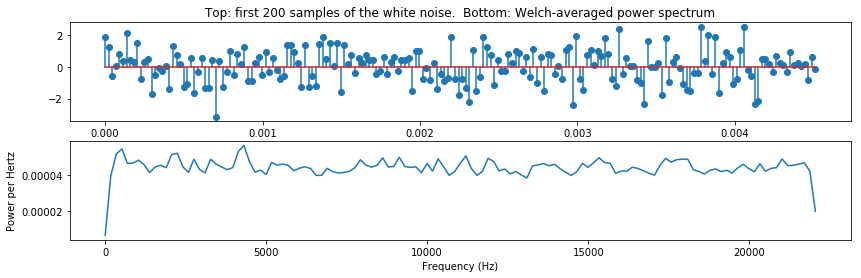

In [73]:
import scipy.signal
(f_welch,E_welch) = scipy.signal.welch(e,fs=fs)
plt.figure(figsize=(14,4))
plt.subplot(211)
plt.stem(t_axis[0:200],e[0:200])
plt.title('Top: first 200 samples of the white noise.  Bottom: Welch-averaged power spectrum')
plt.subplot(212)
plt.plot(f_welch,E_welch)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power per Hertz')

### 1.b. Filtering = Front cavity, in front of the constriction
Here's a cutaway picture of the vocal tract, from https://en.wikipedia.org/wiki/Alveolar_consonant.  Numbers on the bottom indicate the articulators.  Numbers on the top indicate the places of articulation.

<img src="http://courses.engr.illinois.edu/ece590sip/sp2018/placesofarticulation.png" />

#### Articulator (the thing that moves)
* 2 = Lips (labial)
* 17 = Tip (apical)
* 16 =  Blade (laminar)
* 15,14 = Body (dorsal)
* 13 = Root (radical)

#### Place of Articulation (the thing it touches)
* 2 = Labial
* 3 = Dental 
* 4 = Alveolar
* 5 = Post-alveolar
* 6 = Pre-palatal
* 7 = Palatal
* 8 = Velar
* 9 = Uvular
* 10 = Pharyngeal
* 11 = Glottal

<img src="http://courses.engr.illinois.edu/ece590sip/sp2018/tube_open.png" />

The figure above shows the vocal tract flipped around, with the fricative constriction (closed) at the left, and the lips (open) at the right.

* At the lips, air pressure is almost zero---it's only a tiny fluctuation around atmospheric pressure, which is almost constant.  This means that most of the air pressure wave reaching the lips, $p_{forward}(x_{lips},t)$ has to be reflected backward with a negative sign.  Let's arbitrarily define "most of" to mean 80 percent:

$$p_{backward}\left(x_{lips},t\right) = - 0.80 p_{forward}\left(x_{lips},t\right)$$

* When that backward wave hits the fricative constriction, most of it can't go through.  So it is reflected forward again, without changing sign.

$$p_{forward}\left(x_{constriction},t\right) = 0.80 p_{backward}\left(x_{constriction},t\right)$$

* In between those two places, there is a delay equal to the length of the cavity, divided by the speed of sound ($c=35,400$cm/s, at body temperature).

$$p_{forward}\left(x_{lips},t\right) = p_{forward}\left(x_{constriction},t-\frac{L}{c}\right)$$

$$p_{backward}\left(x_{constriction},t\right) = p_{backward}\left(x_{lips},t-\frac{L}{c}\right)$$

If you put it all together, you discover that the signal is subtracted from itself, with a delay of $2L/c$.

$$x\left[n\right] = e\left[n\right] - 0.64 x\left[n-\frac{2LF_s}{c}\right]$$

So let's filter the signal in exactly that way.

In [113]:
# tubelength should be the tube length in centimeters
def quarterwaveresonator(excitation,tubelength,fs):
    outputsignal = np.zeros(len(excitation))
    speedofsound=35400
    delayinseconds = 2.0*tubelength/speedofsound
    delayinsamples = max(1,int(delayinseconds*fs))
    print('For tubelength={}cm, fs={}Hz: delay in seconds is {}, delay in samples is {}'.format(tubelength,fs,delayinseconds,delayinsamples))
    for n in range(0,len(outputsignal)):
        if n < delayinsamples:
            outputsignal[n] = excitation[n]
        else:        
            outputsignal[n] = excitation[n] - 0.64*outputsignal[n-delayinsamples]
    # renormalize to unit power
    power = np.average(np.square(outputsignal))
    return(outputsignal/np.sqrt(power))

Try the following with these different lengths:
* L=0.25cm -- labiodental fricative, /f/
* L=0.5cm -- dental fricative, /$\theta$/
* L=1.5cm -- alveolar fricative, /s/
* L=3cm -- post-alveolar fricative, /ʃ/
* L=7cm -- velar fricative, /x/
* L=9cm -- uvular fricative, /X/
* L=13cm -- pharyngeal fricative, /ħ/
* L=18cm -- glottal fricative, /h/

In [120]:
L = 18
x = quarterwaveresonator(e,L,fs)
sf.write('artificialfricative.wav',x,samplerate=fs)

For tubelength=18cm, fs=44100Hz: delay in seconds is 0.001016949152542373, delay in samples is 44


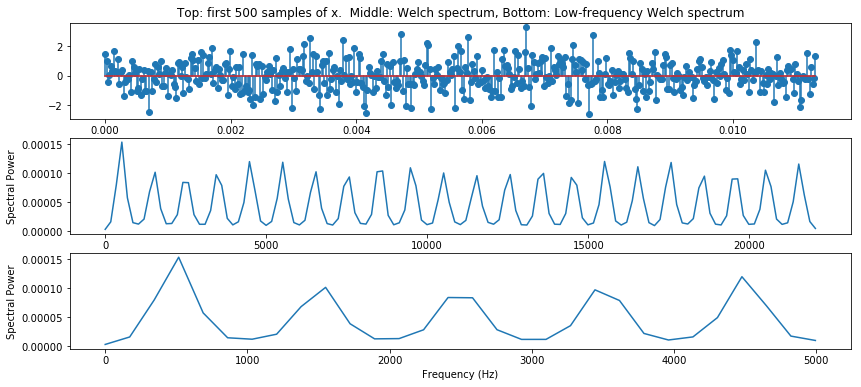

In [121]:
plt.figure(figsize=(14,6))
plt.subplot(311)
plt.stem(t_axis[0:500],x[0:500])
plt.title('Top: first 500 samples of x.  Middle: Welch spectrum, Bottom: Low-frequency Welch spectrum')
plt.subplot(312)
(f_welch,X_welch) = scipy.signal.welch(x,fs=fs)
plt.plot(f_welch,X_welch)
plt.ylabel('Spectral Power')
plt.subplot(313)
f_lowfreq = f_welch[np.where(f_welch < 5000)]
X_lowfreq = X_welch[np.where(f_welch < 5000)]
plt.plot(f_lowfreq,X_lowfreq)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Spectral Power')

#### Why "quarter wave resonator"?

Notice that the spectrum above has peaks at the frequencies

$$F_n = \frac{c}{4L} + (n-1)\frac{c}{2L}$$

These are the resonant frequencies of a uniform tube of length $L$.  If the uniform tube is from glottis to lips, we would call these "formants"; if the uniform tube is just the cavity in front of the fricative constriction, we call these "front cavity resonances".

Since the wavelength of a sound is $\lambda = c/F_n$, these resonances correspond to waves where the tube length, $L$, is $(\lambda/4)$, $3\lambda/4$, and so on:

$$L = \frac{2n+1}{4} \lambda_n$$

Thus, we call a tube like this (open at one end, closed at the other) a "quarter-wave resonator."

## 2. Examples from Wikipedia

Let's download examples from wikipedia, and create spectrograms, to see what they look like.  You should be able to see the quarter-wave resonance for every fricative except /$\theta$/ and /f/; those two have resonances that are too high, so their spectra just look flat.

In [123]:
import soundfile as sf
import io
consonant_pathnames = {
    'f' : '3/33/Voiceless_labiodental_fricative',
    'v' : '8/85/Voiced_labiodental_fricative',
    'θ' : '8/80/Voiceless_dental_fricative',
    'ð' : '6/6a/Voiced_dental_fricative',
    's' : 'a/ac/Voiceless_alveolar_sibilant',
    'z' : 'c/c0/Voiced_alveolar_sibilant',
    'ʃ' : 'c/cc/Voiceless_palato-alveolar_sibilant',
    'ʒ' : '3/30/Voiced_palato-alveolar_sibilant',
    'ɕ' : '0/0b/Voiceless_alveolo-palatal_sibilant',
    'ʑ' : '1/15/Voiced_alveolo-palatal_sibilant',
    'x' : '0/0f/Voiceless_velar_fricative',
    'ɣ' : '4/47/Voiced_velar_fricative',
    'X' : 'c/c8/Voiceless_uvular_fricative',
    'ʁ' : 'a/af/Voiced_uvular_fricative',
    'ħ' : 'b/b2/Voiceless_pharyngeal_fricative',
    'ʕ' : 'c/cd/Voiced_pharyngeal_fricative',
    'h' : 'd/da/Voiceless_glottal_fricative',
    'ɦ' : 'e/e2/Voiced_glottal_fricative'
}
        
consonant_waves = {}
import os
import os.path
if not os.path.exists('wikisounds'):
    os.mkdir('wikisounds')

for c_ipa,c_pathname in consonant_pathnames.items():
    c_url = 'https://upload.wikimedia.org/wikipedia/commons/{}.ogg'.format(c_pathname)
    try:
        req = request.urlopen(c_url)
    except request.HTTPError:
        print('Unable to download {}'.format(c_url))
    else:
        c_wav,c_fs = sf.read(io.BytesIO(req.read()))
        c_filename = 'wikisounds/' + c_ipa + '.wav'
        sf.write(c_filename,c_wav,c_fs)
        consonant_waves[c_ipa] = c_wav

print('Donwnloaded these phones: {}'.format(consonant_waves.keys()))

Donwnloaded these phones: dict_keys(['f', 'v', 'θ', 'ð', 's', 'z', 'ʃ', 'ʒ', 'ɕ', 'ʑ', 'x', 'ɣ', 'X', 'ʁ', 'ħ', 'ʕ', 'h', 'ɦ'])


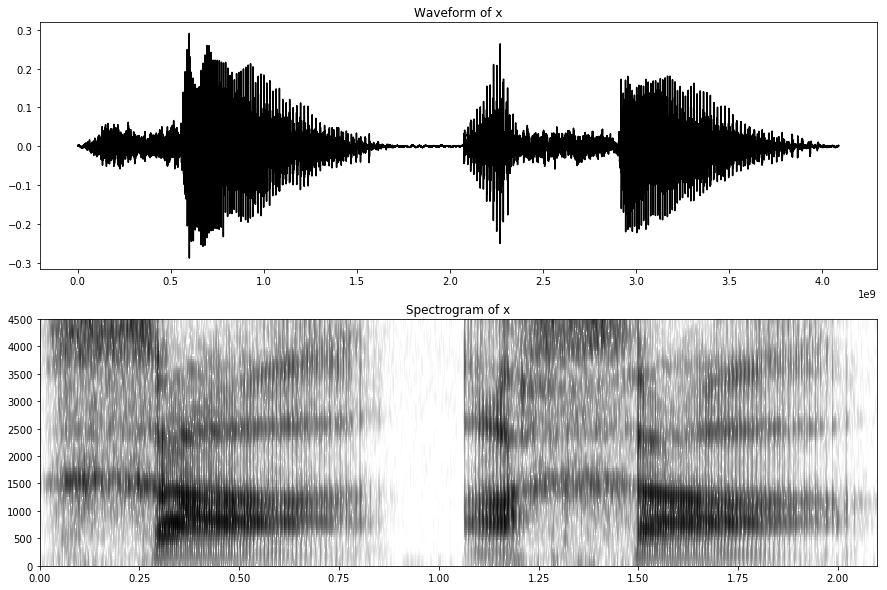

In [127]:
import spectrogram as sg
skip = int(0.002*fs)
windowlen = int(0.006*fs)

c_ipa = 'x'
wav1 = consonant_waves[c_ipa]
(S1,Ext1)=sg.sgram(wav1,skip,windowlen,1024,c_fs,4500,alpha=0.98)
plt.figure(figsize=(15,10))
plt.subplot(211)
times1 = np.linspace(0,c_fs*len(wav1),len(wav1))
plt.plot(times1,wav1,'k')
plt.title('Waveform of {}'.format(c_ipa))
plt.subplot(212)
im1=plt.imshow(S1,origin='lower',extent=Ext1,aspect='auto')
im1.set_cmap('Greys')
plt.title('Spectrogram of {}'.format(c_ipa))


## 3. A mystery sentence
The following sentence includes each fricative in the English language (/f,v,θ,ð,s,z,ʃ,ʒ/) exactly once.  It also has one occurrence, each, of the consonants /b,l,r/.  

Hints: Find the /s,z,ʃ,ʒ/ first; they're obvious by their spectral peaks.  Figure out which is voiced and which is unvoiced, based on their voicebars, and based on their durations.  Find the /r/; it's obvious (the /l/ is not).  Then, for the remaining consonants, try to figure out which one is /b/, and which ones are /f,v,θ,ð/.

It might help you if you decode the vowels too.  I was wrong about /o/ and /e/ last time; their formants are more like /ʊ/ and /ɪ/, respectively, than like /ɔ/ and /ɛ/.  In fact, the main way in which /o,e/ differ from /ʊ,ɪ/, in English, is that /o,e/ are much longer.

In [132]:
data, fs = sf.read(io.BytesIO(request.urlopen('http://courses.engr.illinois.edu/ece590sip/sp2018/mystery2018mar07.wav').read()))
time1_1 = 0
time1_2 = time1_1+1.5
time2_1 = time1_2-0.2
time2_2 = time2_1+1.5
wav1 = data[int(time1_1*fs):int(time1_2*fs)]
N = len(wav1)
wav2 = np.zeros(N)
wav2[0:min(N,len(data)-int(time2_2*fs))] = data[int(time2_1*fs):min(len(data),int(time2_2*fs))]
# Create a t axis, then plot the waveform as a function of n, and as a function of t
times1 = np.linspace(time1_1,time1_2,N)
times2 = np.linspace(time2_1,time2_2,N) 


(0, 1.485, 0, 4500)

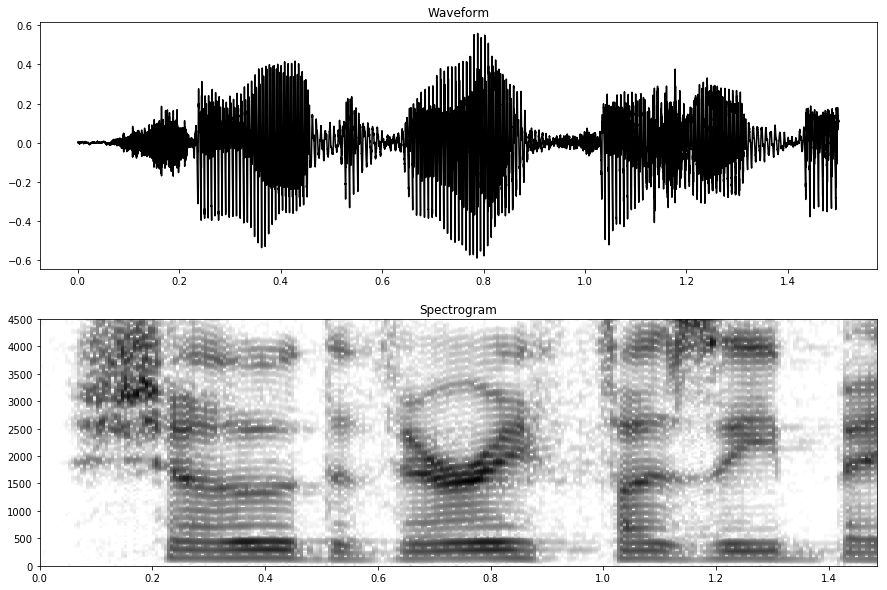

In [133]:
(S1,Ext1)=sg.sgram(wav1,skip,windowlen,1024,fs,4500,alpha=0.98,start_time=time1_1)
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(times1,wav1,'k')
plt.title('Waveform')
plt.subplot(212)
im2=plt.imshow(S1,origin='lower',extent=Ext1,aspect='auto')
im2.set_cmap('Greys')
plt.title('Spectrogram')
Ext1

(1.3, 2.785, 0, 4500)

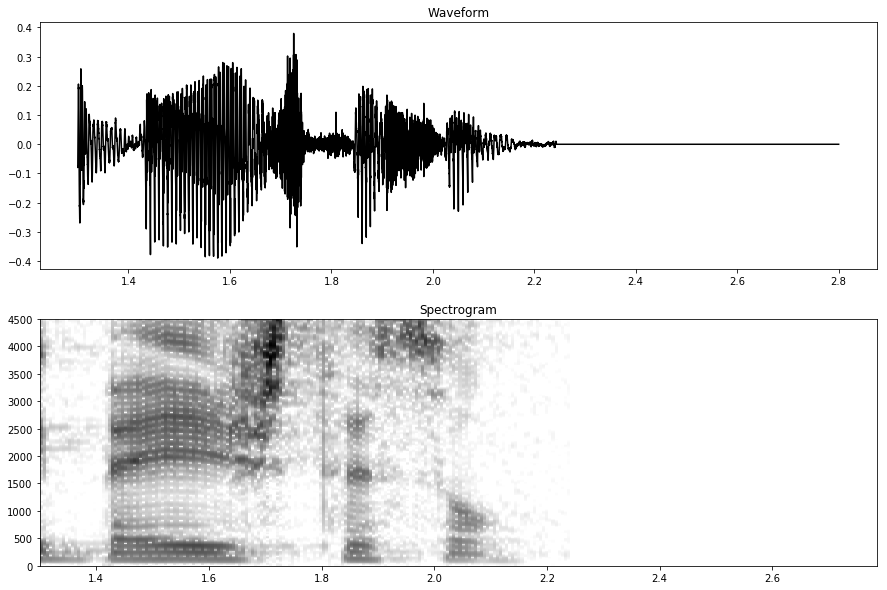

In [134]:
(S2,Ext2)=sg.sgram(wav2,skip,windowlen,1024,fs,4500,alpha=0.98,start_time=time2_1)
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(times2,wav2,'k')
plt.title('Waveform')
plt.subplot(212)
im2=plt.imshow(S2,origin='lower',extent=Ext2,aspect='auto')
im2.set_cmap('Greys')
plt.title('Spectrogram')
Ext2

<img src="http://courses.engr.illinois.edu/ece590sip/sp2018/PetersonBarneyVowels.png" />